In [108]:
# The code was removed by DSX for sharing.

# Analyse images on CloudObjectStorage using Mathematical Morphology methods in openCV


max three paragraphs

Include at least one and no more than three introductory paragraphs. Introduce the tutorial, describe the data, and set expectations for what the tutorial will provide. If necessary, add assumptions about what the reader should know or have access to before starting the tutorial. You can include very simple prerequisites here, but put anything requiring steps or additional explanation in the Setup section.

Include the language and Spark versions that you've verified work for the notebook.


Mathematical Morphology (MM) is a technique based on set theory to analyse structures in images. It is different from other image processing methods in that it operates with entities like 'connected components', 'neighborhoods' or 'structural elements'. Several implementations of MM exist, including the Matlab Image Processing Library and the python xxx libraries. In this notebook the python interface to the 'openCV' open source library will be used and its installation and use explained.

The application presented is designed to help the barista optimize the coffee brewing process by measuring the size distribution of the coffee grind particles. The coffee brewing process is influenced by several factors, including brewing time, water pressure and temperature and the coffee grind size. The latter is mutually adjusted with the others to find the sweet spot of perfect taste for a given coffee bean roast and brewing technology (see e.g. https://www.homegrounds.co/coffee-grind-chart or https://ineedcoffee.com/coffee-grind-chart). The input data is an image of suitably prepared coffee grind taken using a low magnification microscope. MM operations including erosion, dilation, opening, closing, tophat, geodesic distance and waterfall transform are used to identify and isolate grind particles such that their size in terms of pixels can be measured.

This notebook requires a basic understanding of python and the DSX environment. Some prior knowledge about MM is required to fully understand the operations employed, but the many plots of intermediate processing results should provide a general idea of the power of a MM pipeline. No introduction to MM will be given as many good resources can be found on the web. DSX Cloud Object Storage and Data Catalog are used to store the images being analysed. 


Originally designed for black and white images extensions to grayscale have been devised and are used here.

## Table of Contents

## Preparation
bla fasel
Main section titles use heading level 2. If you numbered the sections in the table of contents, number them here.

Use imperative verbs in the title when possible and try to provide the goal of the section.

Use subsections (H3s) for distinct setup tasks if you have more than two or three simple tasks. Add links to the subsections at the beginning of the section.

Provide a paragraph to explain what the main section does. Even if the section has multiple subsections, summarize the goal of the overall section here. If the section simply has code, explain what the code does.

The setup section is optional: use it if your notebook has steps that are outside of DSX.

Explain what setup tasks are needed and whether they need to be repeated or are one-time only. Setup tasks include any prerequisites for the notebook tasks, such as creating accounts, authenticating, accessing data for future steps, or importing modules.

### Installation of openCV and libraries for image processing

bla fasel

In [109]:
!pip install --user opencv-python
!pip install --user imageio
#!pip list --format=columns

bla fasel

In [110]:
# imports for image processing
import cv2
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import io
from mpl_toolkits.mplot3d import Axes3D



In [111]:
cgsDefPlotSize=[12,12]
mpl.rcParams['figure.figsize'] = cgsDefPlotSize

### Insert DSX project token

* click th '...' icon in the top right menu bar
* click 'insert project token'

### Upload image to DataCatalog

- Goto Project overview page
- Upload image file from https:// to DataCatalog
- Add image to project (also adds connection to Data catalog

### Insert DSX credentials


- switch to this notebook
- Open the right panel data menu by clicking the '1010' icon
- locate the image
- select 'insert credentials' from the dropdown box
- change the variable name to 'creds'


In [112]:
# The code was removed by DSX for sharing.

## Load Data


Most notebooks have tasks around getting and loading data. Include a short description of the data set and how to get it.

If you are using open data sets, make sure that you describe the data set in your own words instead of copying the description of the data set from the source. Any text that's copied from a non-IBM site is a copyright infringement, except for data citations. For open data sets, you must include data citations (see Data citations). You can modify an open data set and supply a link to it in GitHub, but you must identify the original source of the data and include data citations.


### Insert code to read image

- select 'Insert streaming body object' from 'insert to code' dropdown
- rename the 'client_.....' variable to client_coffee
- insert a cell and move the

In [113]:

import sys
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
cgsClient = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=cgsCreds['IBM_API_KEY_ID'],
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')
type(cgsClient)

ibm_botocore.client.S3

In [114]:
cgsBucket = 'bluercatalogobjectstorageservic-bjl1cteg-catalog-e46366c1';

In [115]:
# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about your possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/

# Method to read image from cos into numpy.ndarray
def cgsReadImage(client, bucket, file):
    isr = client.get_object(Bucket=bucket, Key=file)['Body']
    if not hasattr(isr, "__iter__"): isr.__iter__ = types.MethodType( __iter__, isr )
    return(io.imread(isr))

### Read image Read image as stream into ndarray

## The CoffeeGrindSieve

The idea of the CoffeeGrindSieve is to take an image of the cofee grind, identify the coffee grind particles, count these and to measure their size. The final result shall be a histogram representing the distribution of the size of the particles. The distribution will hopefully be parameterizable in terms of e.g. mean and variance, indicating the size and uniformity of the coffee grind particles for a particular mill and coarseness setting.

The first part of the pipeline will identify the pixels representing coffee grind:
- convert rgb image to graylevel using high contrast channel
- remove background to obtain uniform lightning conditions using the MM tophat transform
- regard the graylevels of the image as levels of a Digital Elevation Model (DEM) with black representing valleys and white peaks
- convert to binary (BW) image by thresholding, with white pixels identifying coffee grind

The second part of the pipeline will identify the individual particles of the coffee grind. The challenge here is to find suitable paths to cut overlapping or otherwise cohesive particles: 
- calculate the MM geodesic distance transform of the BW image to obtain a measure of connectedness as a DEM
- threshold the geodesic distance transform to seperate weakly connected sections
- regard the resulting patches as markers for individual coffee grind particles

Finally, the pixels belonging to the individual coffee grind particles are identified and counted to obtain the distribution of the particle size:
- reconstruct the complete coffee grind particles by growing their markers within the boundaries of the pixels identifying coffee grind (step 1)
- use the MM watershed transform to identify each coffee grind particle as an area of connected pixels, that is, as MM connected components
- calculate the size of each connected component and etablish the distribution in terms of number of pixels

Starting from a crude image of coffee grind taken under a low magnification microscope some practical problems will be encountered requiring additional steps. These will be discussed in the upcoming sections. 


### Input Image

(2976, 3968, 3) 35426304 uint8


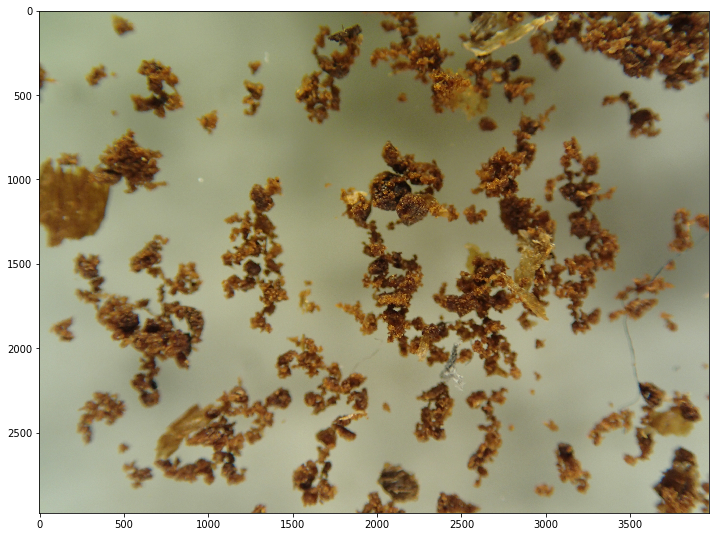

In [116]:
cgsImage = 'data_asset/CoffeeGrind_rkTlR3bKz.jpg'
jpg = cgsReadImage(cgsClient, cgsBucket, cgsImage)
print(jpg.shape, jpg.size, jpg.dtype)
plt.imshow(jpg)
plt.show()

### Identify coffee grind pixels

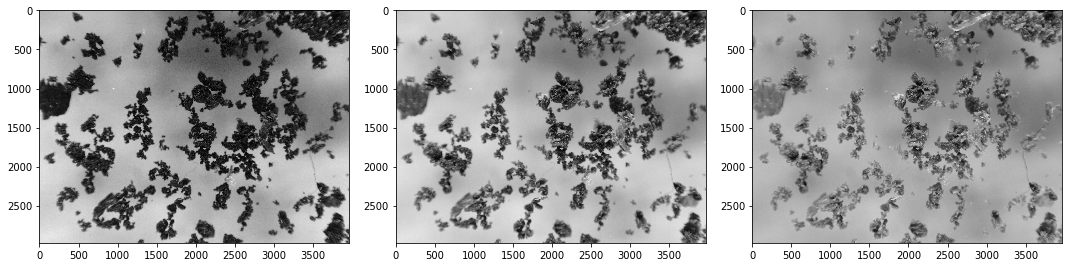

In [117]:
b,g,r = cv2.split(jpg)

mpl.rcParams['figure.figsize'] = [15,15]
plt.subplot(1,3,1)
plt.imshow(r,cmap= 'gray')
plt.subplot(1,3,2)
plt.imshow(g,cmap = 'gray')
plt.subplot(1,3,3)
plt.imshow(b,cmap = 'gray')
plt.tight_layout()
plt.show()
mpl.rcParams['figure.figsize'] = cgsDefPlotSize


(744, 992) 738048 uint8


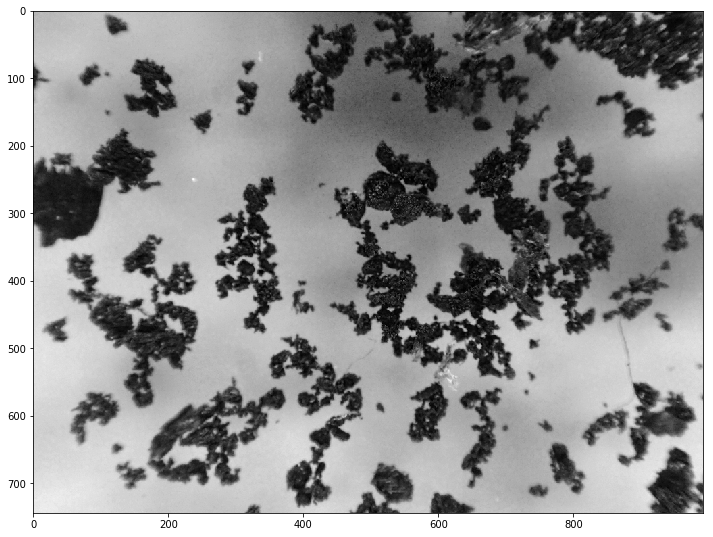

In [118]:
# select red channel for further processing
gray = r

k = 4
gray = cv2.resize(gray, None, fx=1/k, fy=1/k, interpolation = cv2.INTER_LINEAR)
print(gray.shape, gray.size, gray.dtype)
plt.imshow(gray, cmap='gray')
plt.show()

In [119]:
def cgsPlot3d(img, s=1, e=75):
    # 3d plot of dist transform
    fig = plt.figure(figsize = (20,20))
    ims = cv2.resize(img, None, fx=1/s, fy=1/s, interpolation = cv2.INTER_LINEAR)
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=e)
    xx, yy = np.mgrid[0:ims.shape[0], 0:ims.shape[1]]
    ax.plot_surface(xx, yy, ims, rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
    plt.show()

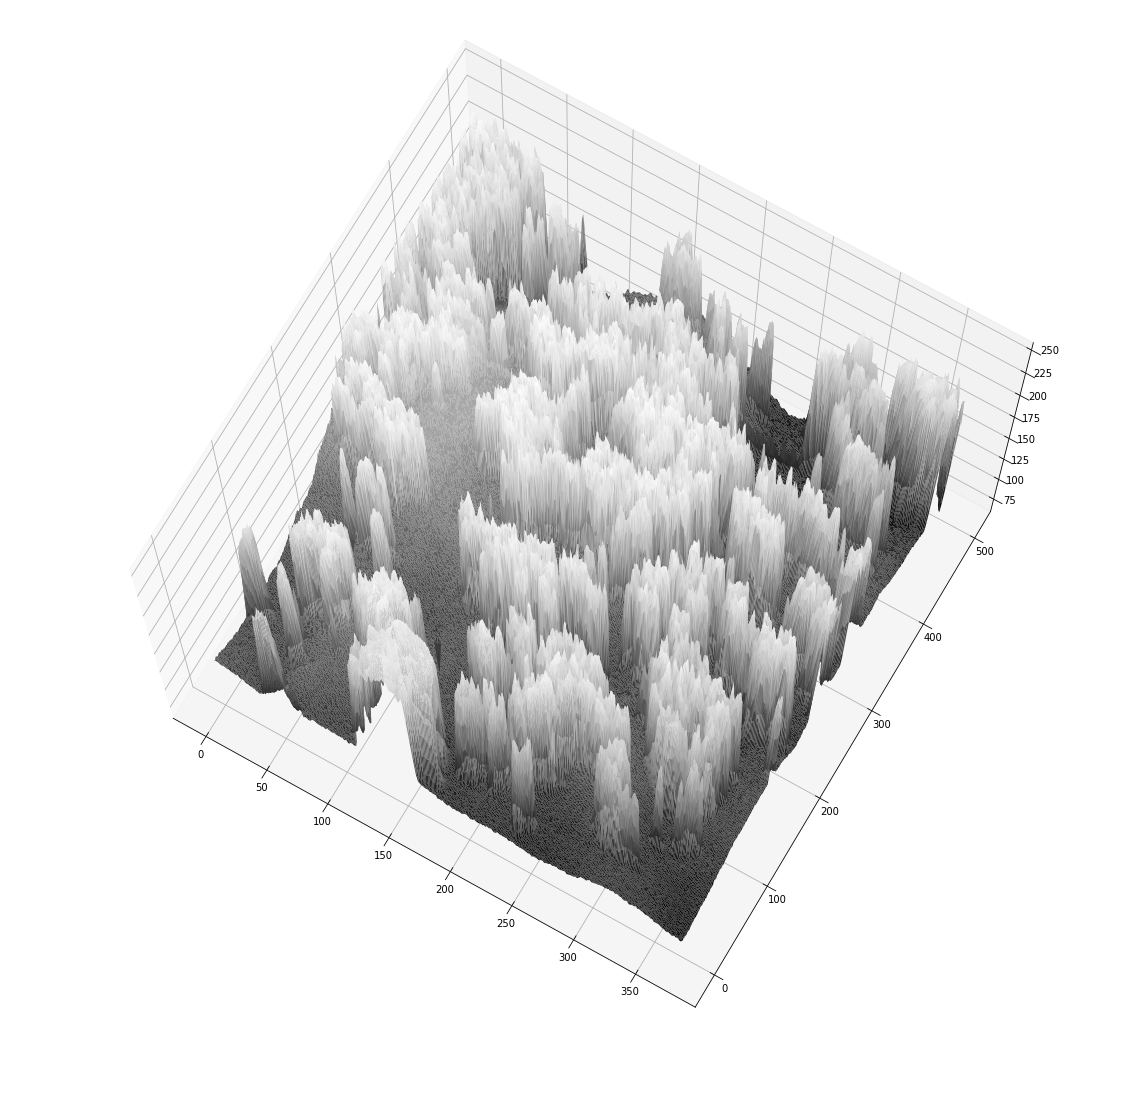

In [120]:
cgsPlot3d(-gray, s=2)

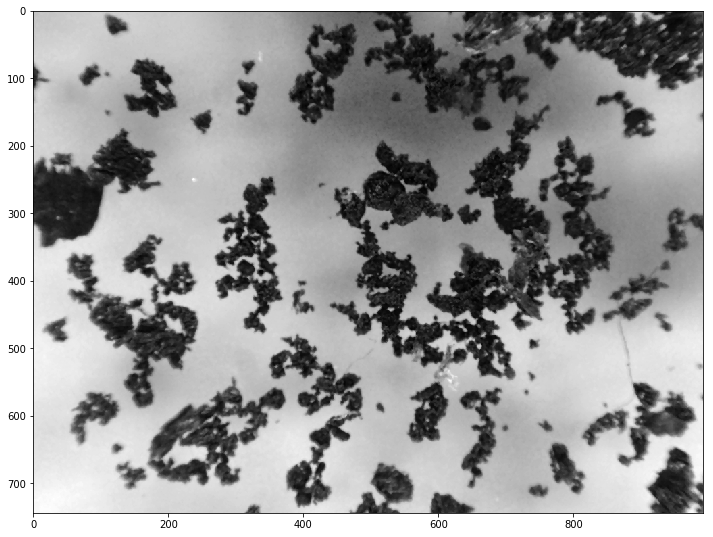

In [121]:
# Edge presering smoothing
h = 3
smooth = cv2.medianBlur(gray, h)
plt.imshow(smooth, cmap='gray')
plt.show()

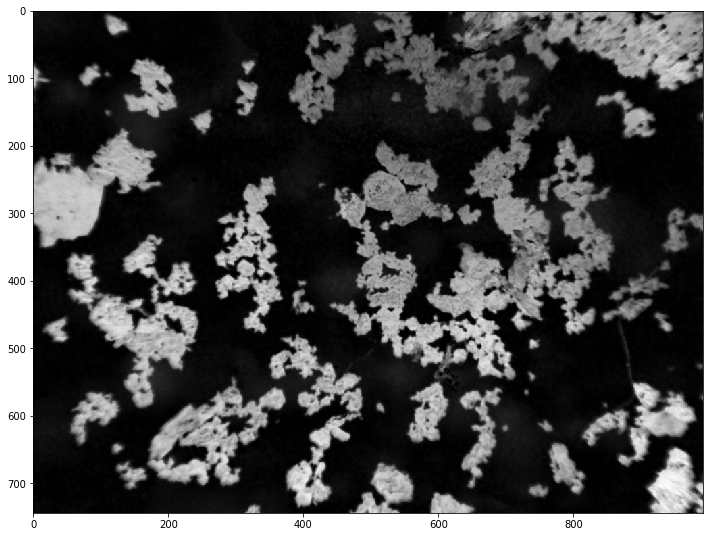

In [122]:
# strel size experimental --> will be 25*8=200 for original size
t=np.int(500/k)
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
tophat = cv2.morphologyEx(smooth, cv2.MORPH_BLACKHAT, strel)
plt.imshow(tophat, cmap='gray')
plt.show()

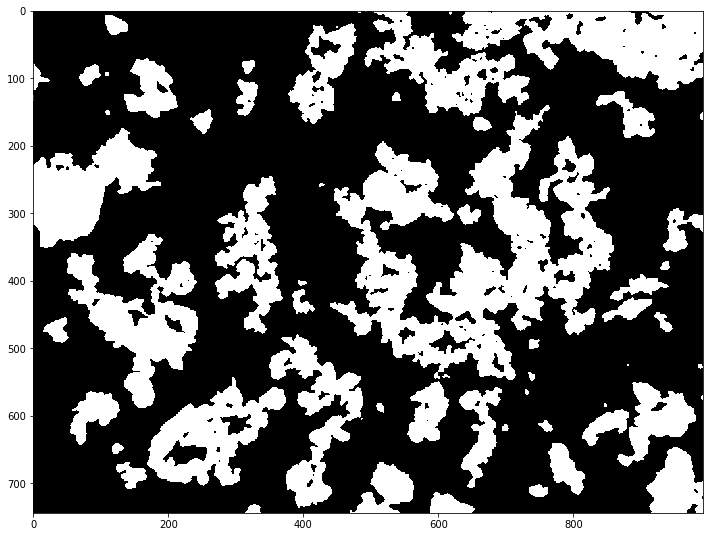

In [123]:
# convert to BW. Threshold experimental
b = 32
bw = cv2.threshold(tophat,b, 255, cv2.THRESH_BINARY)[1]
plt.imshow(bw, cmap='gray')
plt.show()

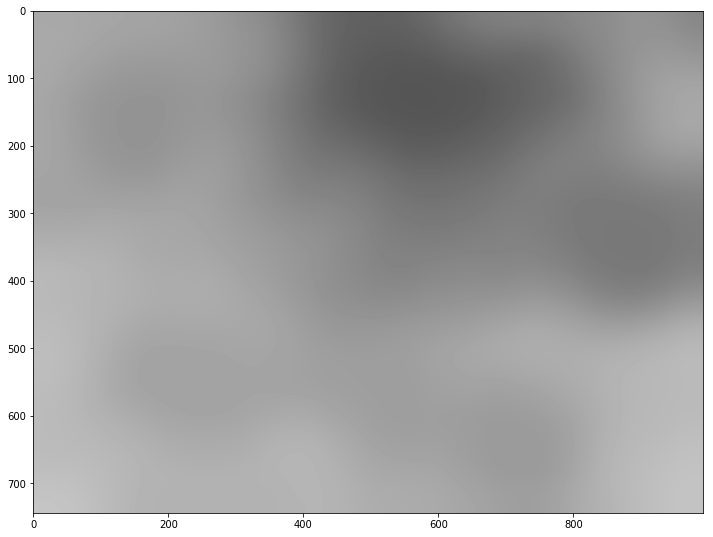

In [124]:
# calculate smooth background
gb = 99
bg = smooth + tophat
bgs = cv2.GaussianBlur(bg,(gb,gb),gb)
plt.imshow(bgs, cmap='gray', vmin=0, vmax=255)
plt.show()

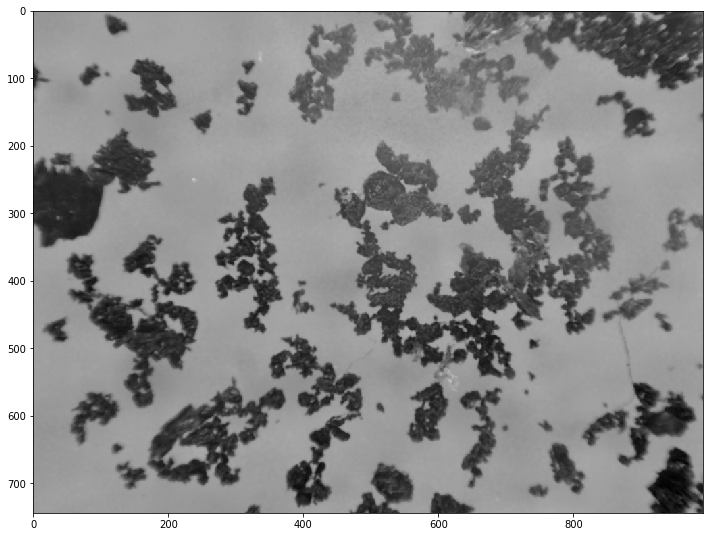

In [125]:
flat = (512+smooth)-bgs
flat = flat - flat.min()
flat = np.uint8(flat)
plt.imshow(flat, cmap='gray', vmin=0, vmax=255)
plt.show()

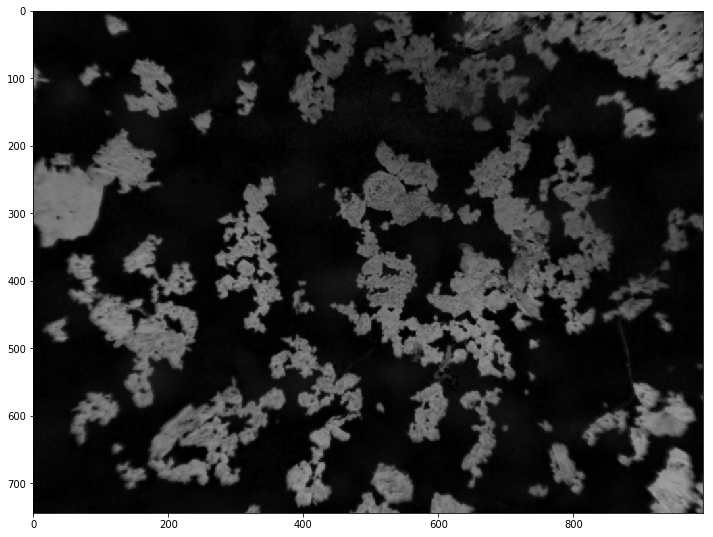

In [126]:
t=np.int(500/k)
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(t,t))
tophat2 = cv2.morphologyEx(flat, cv2.MORPH_BLACKHAT, strel)
plt.imshow(tophat2, cmap='gray', vmin=0, vmax=255)
plt.show()

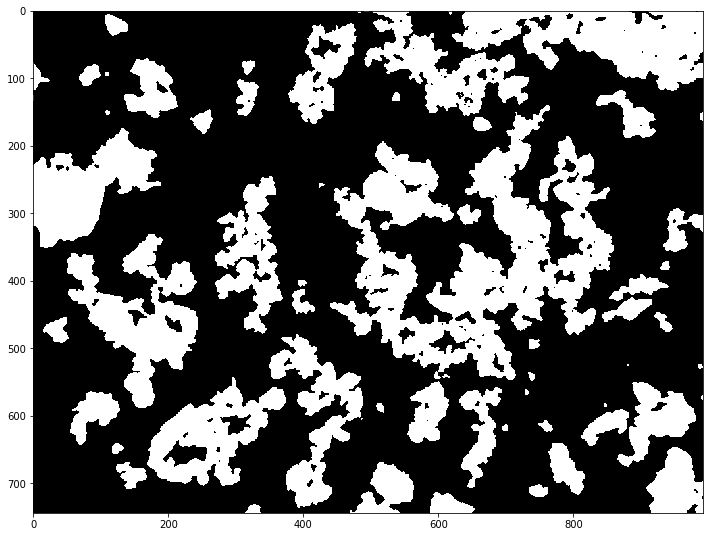

In [127]:
plt.imshow(tophat2>32, cmap='gray')
plt.show()

In [128]:
# fill small holes
c=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(c,c))
bw1 = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, strel)

In [129]:
# remove small particles
o=3
strel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(o,o))
bw2 = cv2.morphologyEx(bw1, cv2.MORPH_OPEN, strel)

### Cut into particle seeds

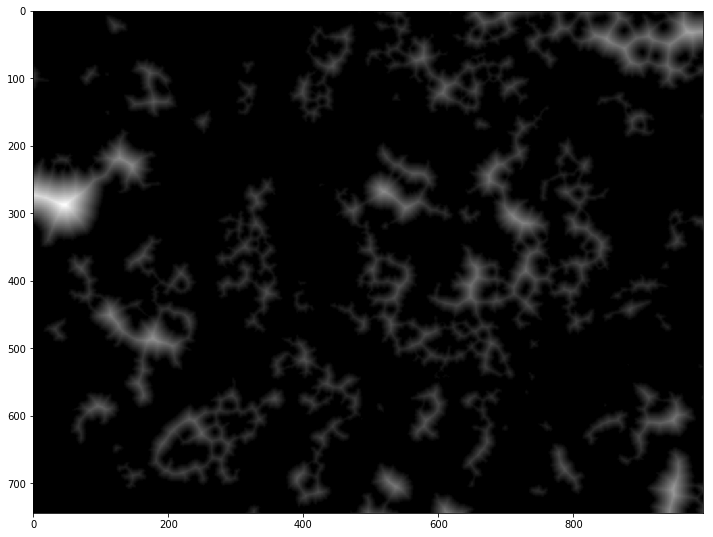

In [130]:
# distanceTransform
dt = cv2.distanceTransform(bw2, distanceType=cv2.DIST_L2, maskSize=cv2.DIST_MASK_PRECISE)
plt.imshow(dt/dt.max()*255, cmap='gray', vmin=0, vmax=255)
plt.show()

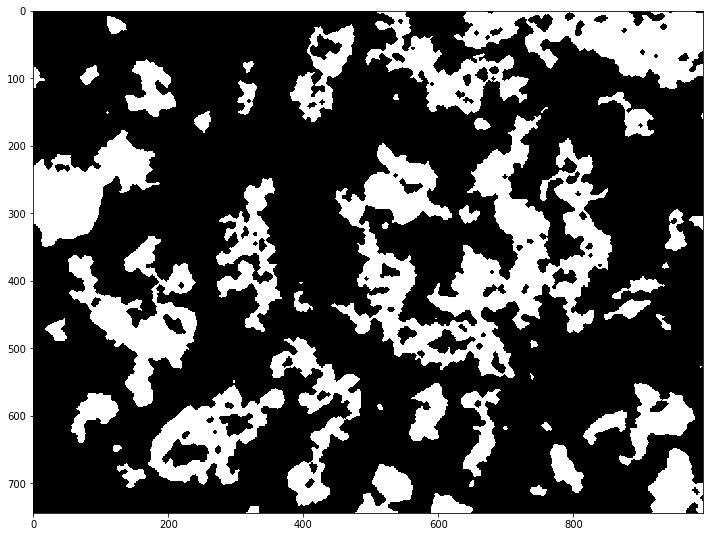

In [131]:
se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))

# Threshold 1: Low threshold on distance transform
t2=2
dt1 = cv2.threshold(dt,t2, 255, cv2.THRESH_BINARY)[1]
dt1 = cv2.morphologyEx(dt1, cv2.MORPH_OPEN, se)
dt1 = np.uint8(dt1)
plt.imshow(dt1, cmap='gray', vmin=0, vmax=255)
plt.show()

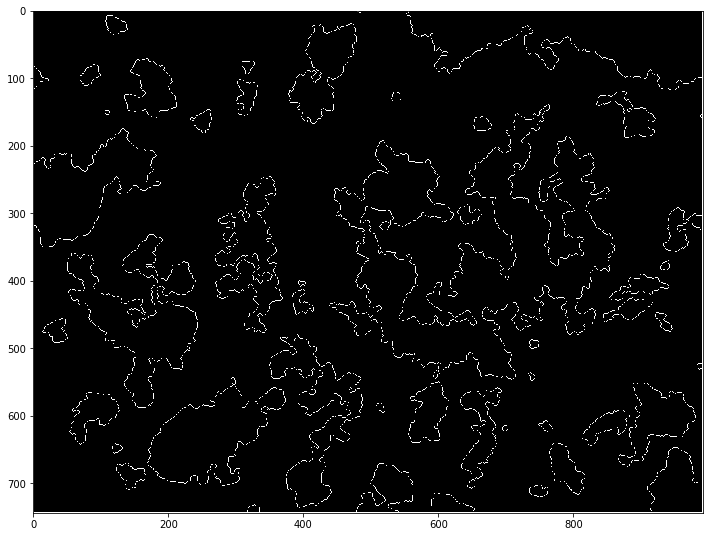

In [132]:
# identify marker regions
n,cc1 = cv2.connectedComponents(dt1)

# construct watershed from tophat and connected components
rgb = cv2.cvtColor(255-tophat, cv2.COLOR_GRAY2BGR)
ws1 = cv2.watershed(rgb,cc1)
seg1 = (ws1==-1)*255
plt.imshow(seg1, cmap='gray', vmin=0, vmax=255)
plt.show()

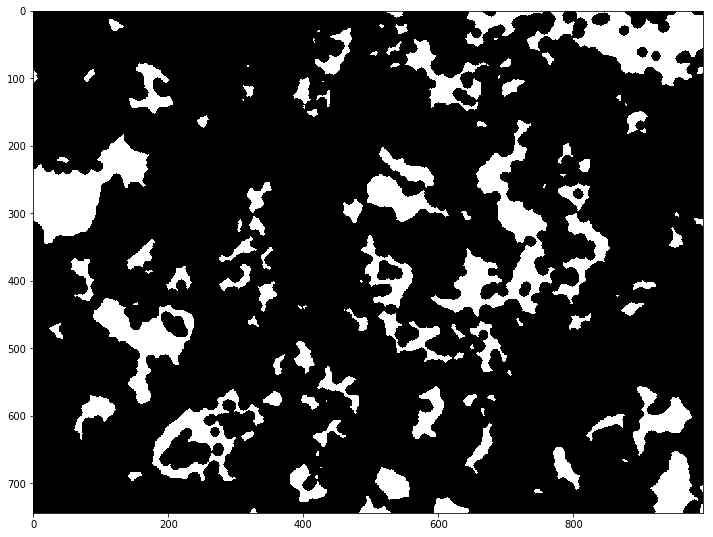

In [133]:
# Threshold 2: High threshold on distance transform
t2=6
dt2 = cv2.threshold(dt,t2, 255, cv2.THRESH_BINARY)[1]
dt2 = cv2.morphologyEx(dt2, cv2.MORPH_OPEN, se)
dt2 = np.uint8(dt2)
plt.imshow(dt2, cmap='gray', vmin=0, vmax=255)
plt.show()

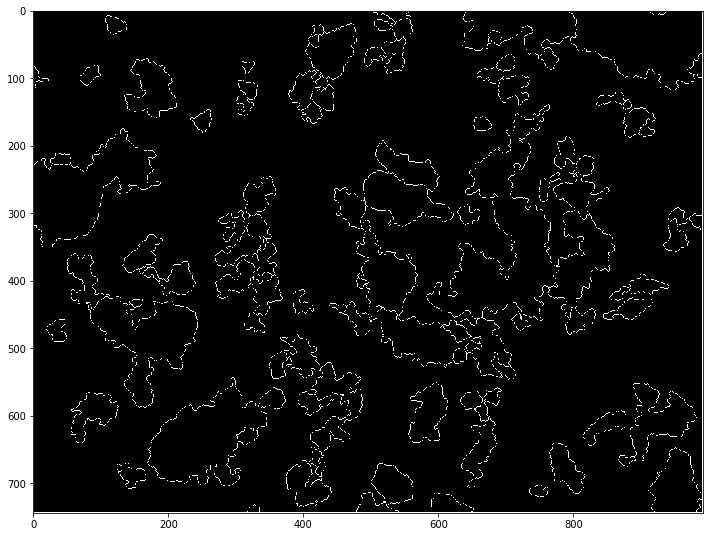

In [134]:
# identify marker regions
n,cc2 = cv2.connectedComponents(dt2)

# construct watershed from tophat and connected components
rgb = cv2.cvtColor(255-tophat, cv2.COLOR_GRAY2BGR)
ws2 = cv2.watershed(rgb,cc2)
seg2 = (ws2==-1)*255
plt.imshow(seg2, cmap='gray', vmin=0, vmax=255)
plt.show()

### Obtain connected components

In [135]:
# Final connected components: Merge the watersheds

# Set watersheds to 0 an dconvert to uint8
ws1[ws1==-1]=0
ws2[ws2==-1]=0
ws1 = np.uint8(ws1)
ws2 = np.uint8(ws2)

In [136]:
# remove background.  different on every litte  change. weird
h1 = cv2.calcHist([ws1],[0],None,[256],[0,256])
b1 = np.where(h1==h1.max())[0][0]
ws1[ws1==b1]=0
h2 = cv2.calcHist([ws2],[0],None,[256],[0,256])
b2 = np.where(h2==h2.max())[0][0]
ws2[ws2==b2]=0

In [137]:
# set forground to 255
ws1[ws1>0]=1
ws2[ws2>0]=1
ws12 = ws1+ws2
ws12[ws12>0]=255

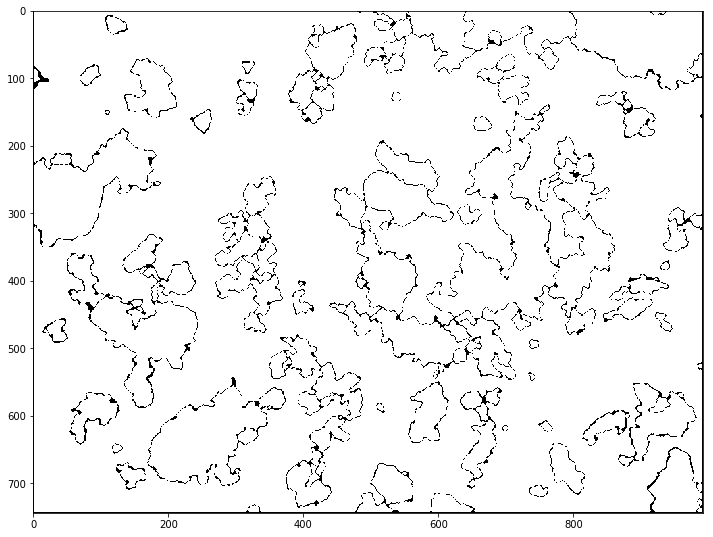

In [138]:
# Merge Watersheds and make walls thicker
seg12 = seg1 | seg2
seg12 = 255-np.uint8(seg12)
seg12 = cv2.morphologyEx(seg12, cv2.MORPH_ERODE, se)
seg12 = cv2.morphologyEx(seg12, cv2.MORPH_CLOSE, se)
seg12 = cv2.morphologyEx(seg12, cv2.MORPH_OPEN, se)
seg12 = cv2.morphologyEx(seg12, cv2.MORPH_DILATE, se)
plt.imshow(seg12, cmap='gray', vmin=0, vmax=255)
plt.show()

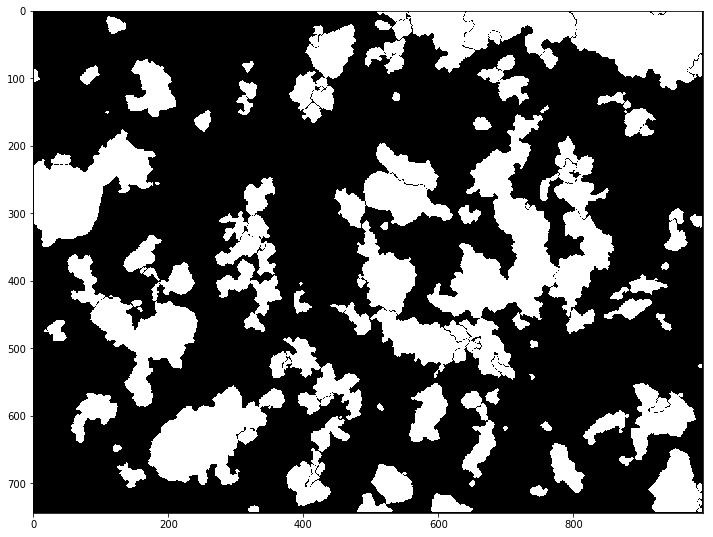

In [139]:
# Impose watersheds on 
wsx = ws12 * seg12 * 255
wsx = np.uint8(wsx)
plt.imshow(wsx, cmap='gray', vmin=0, vmax=255)
plt.show()

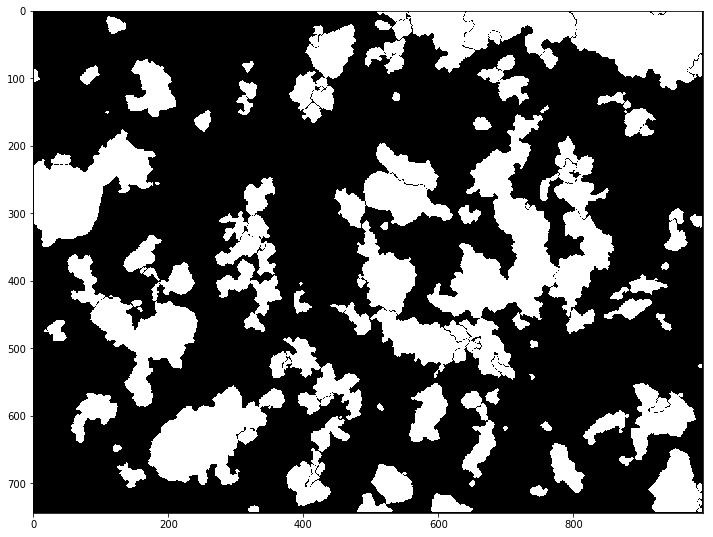

In [140]:
# Impose watersheds on 
wsx = ws12 * seg12 * 255
wsx = np.uint8(wsx)
plt.imshow(wsx, cmap='gray', vmin=0, vmax=255)
plt.show()

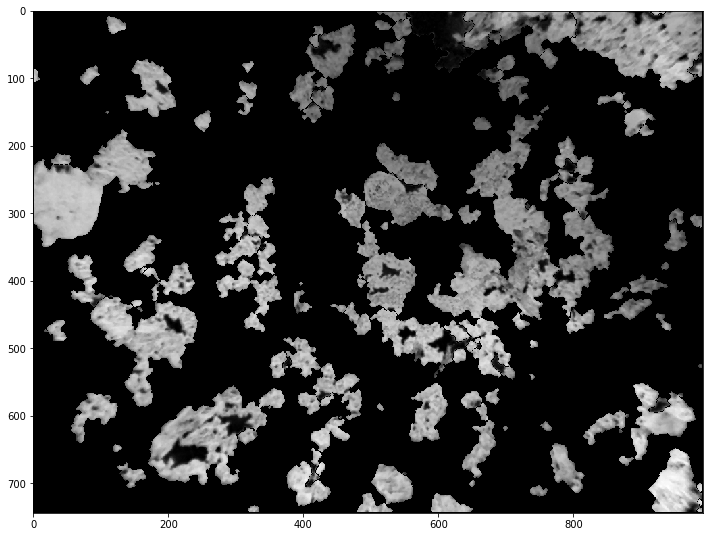

In [141]:
# Impose on tophat
wsth = (wsx/255) * (tophat/tophat.max()*255)
plt.imshow(wsth, cmap='gray', vmin=0, vmax=255)
plt.show()

In [142]:
# Final connected components
cc_n, cc_lbl, cc_stats, cc_cntr = cv2.connectedComponentsWithStats(wsx, connectivity=4)

### Obtain size distribution

In [143]:
def ccHist(cc):
    x = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
    h = np.histogram(cc, bins=2**x)
    fig = plt.figure()
    plt.bar(x[0:16]+0.5,h[0][0:16])
    plt.xticks(x,x)
    plt.grid(); plt.xlim(0,16)
    plt.title("openCV-CoffeeGrinderSieve")
    plt.xlabel("Size of particles [2**n pixels]")
    plt.ylabel("Number of particles")
    plt.show()

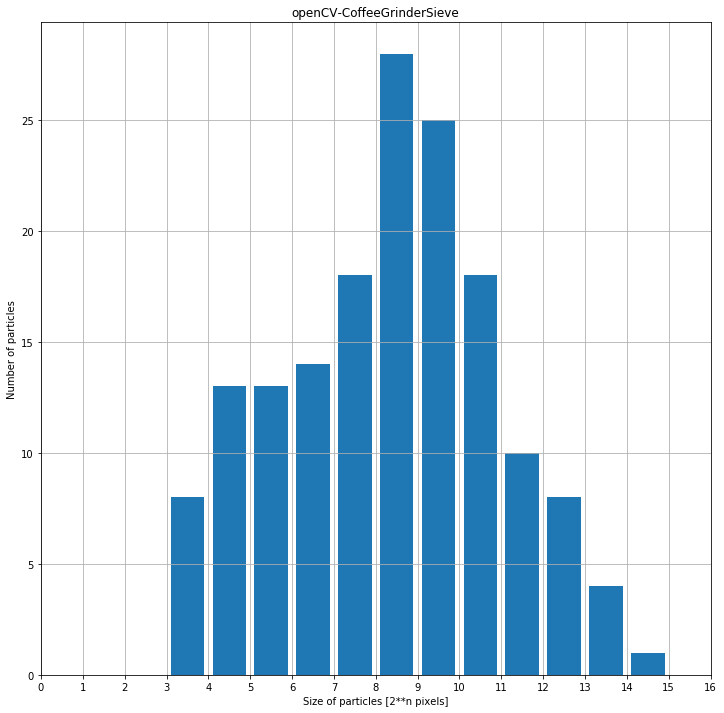

In [144]:
# Area of cc's
cc_area = cc_stats[:,cv2.CC_STAT_AREA]
ccHist(cc_area)

### Example of a section purpose

In this section, you'll download a file from a URL, create an RDD from it, and analyze the text in it.

### How to describe code

It's very important that you describe what the code is doing. Keep your target audience in mind!

*    Give a description of what the command is going to do.
*    Don't put commands for multiple tasks in the same code cell, but it's fine to include importing libraries or showing rows in the same cell as another command.
*    If necessary, describe the results of the command. If it's not obvious, explain what the command did and the significance of the result.
*    If the code contains parameters, make sure you describe what they are, why you set them the way you did, and if applicable, what the default values are.


### Examples of describing a command¶

*    Create a DataFrame and show the inferred schema.
*    Register the DataFrame as a table so that you can run SQL queries on it and show the first two rows.
*    Create a Python collection of the numbers 1 - 10.


### Example of describing an algorithm

Machine learning algorithms have standard parameters and hyperparameters. Standard parameters specify data and options. Hyperparameters control the performance of the algorithm.

The ALS algorithm has these hyperparameters:

*    The rank hyperparameter represents the number of features. The default value of rank is 10.
*    The maxIter hyperparameter represents the number of iterations to run the least squares computation. The default value of maxIter is 10.

Use the training DataFrame to train three models with the ALS algorithm with different values for the rank and maxIter hyperparameters. Assign the userCol, itemCol, and ratingCol parameters to the appropriate data columns. Set the implicitPrefs parameter to true so that the algorithm can predict latent factors.

## Examples of describing command results

*    You created the string "Hello Human" and you returned it as the first element of the RDD.
*    The first print command shows that the DataFrame is a Spark DataFrame. The last print command shows the column names and data types of the DataFrame.
*    The third model (model3) has the lowest mean squared error value, so it's the most accurate.
*    The recommended products look pretty similar to the purchased products, and, in some cases, are actually the same. Your model works!

### Example of instructions for creating a PixieDust graph

Run the display() command and then configure the graph to show the relationship between ‘Lifetime Post Consumption’ and Emotion Tone for articles and posts:

*    Run the next cell. The PixieDust interactive widget appears.
*    Click the chart button and choose Bar Chart. The chart options tool appears.
*    In the chart options tool, drag Lifetime Post Consumption into the Values box.
*    Move Emotion Tone into the Keys box.
*    Set the Aggregation to Avg and click OK. The bar chart appears.
*    From the Cluster By list, choose Type. Now the chart shows separate bars for articles and posts.

If you want to make further changes, click Options to return to the chart options tool.

## Accessing files on Cloud Object Storage

### Upload image into CloadObject Storage

### Credentials 

### Access file as streaming object

### Method to read files

### Method to write files

## Installation of openCV python libraries in DSX

### Read, display and write an image with openCV

## Summary and next steps

Use heading level 2 for your summary section title. The title of this section can be different depending on content. If the title "Summary and next steps" is not appropriate, pick another one. Possibilities include:

*    Summary
*    Next steps
*    Resources
*    Links
*    That's it!
*    What's next
*    Dig deeper

Include a paragraph that reviews what the tutorial covered and what new skills were learned.

Optionally mention any follow-on steps, tasks, or notebooks that the user can do now.

Provide relevant links to notebooks, communities, starter kits, KC topics, forums, and so on. Don't overdo the links. It's best to provide fewer than 5. Links can be in list or paragraph form but should have appropriate titles.

### Authors

Copyright

Don't include a heading for the copyright!

The copyright includes a line above it. In most cases, leave the copyright information the way it is. If you republish a notebook in a later year, include that year: original year, updated year. For example: 2017, 2018.